### Importing library

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.ensemble import BaggingClassifier
from sklearn.feature_selection import SequentialFeatureSelector
import time
import itertools
import statsmodels.api as sm
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score
import imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTENC

from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

from xgboost import plot_importance

import warnings
warnings.filterwarnings("ignore")

import os 
os.chdir(r"C:\Users\Lucas\Desktop\econometrie big data\second year\projet\data")

In [2]:
pd.set_option('display.max_columns', None)

### Import dataset 
We import the dataset and remove variables that correspond to IDs

In [3]:
df = pd.read_csv("churn_telecom.csv")

display(df)

df.drop(columns=["customer_id","random_string"],inplace=True)

customer_id  age  gender region  tenure_months   contract_type  \
0               1   69  Female  North             96  Month-to-month   
1               2   32  Female   East             24  Month-to-month   
2               3   78  Female   East             51         2 years   
3               4   38  Female  North             58  Month-to-month   
4               5   41  Female   East             29  Month-to-month   
...           ...  ...     ...    ...            ...             ...   
7995         7996   42  Female  North             84  Month-to-month   
7996         7997   72    Male  North            101          1 year   
7997         7998   57  Female   West             40          1 year   
7998         7999   67    Male   West             32  Month-to-month   
7999         8000   50    Male  North             92          1 year   

      monthly_charges  total_charges payment_method paperless_billing  \
0               67.69        6528.56     CreditCard               Yes   
1               51.43        1200.88    DirectDebit               Yes   
2               31.65        1542.75     CreditCard               Yes   
3                6.33         240.93     CreditCard               Yes   
4              127.43        3761.73   BankTransfer                No   
...               ...            ...            ...               ...   
7995            57.85        4783.51     CreditCard               Yes   
7996            88.32        8886.15    DirectDebit               Yes   
7997            13.44         542.38    DirectDebit                No   
7998            56.49        1780.30   BankTransfer               Yes   
7999            56.09        5144.04   BankTransfer               Yes   

     internet_service online_security tech_support streaming_tv  \
0          FiberOptic              No          Yes           No   
1                 DSL              No           No           No   
2                 DSL             Yes           No           No   
3                 DSL              No           No          Yes   
4          FiberOptic              No           No           No   
...               ...             ...          ...          ...   
7995              DSL              No          Yes           No   
7996       FiberOptic             Yes           No           No   
7997              NaN             Yes          Yes           No   
7998              DSL              No           No           No   
7999              DSL              No           No           No   

     streaming_movies  num_services  avg_call_duration  num_complaints  \
0                  No             1               3.27               0   
1                 Yes             2               9.02               0   
2                  No             1               1.74               0   
3                  No             2               3.36               0   
4                 Yes             2               7.48               0   
...               ...           ...                ...             ...   
7995               No             1               3.20               0   
7996              Yes             2               0.00               0   
7997               No             1               5.09               0   
7998              Yes             2               0.00               0   
7999              Yes             2               5.38               0   

      customer_satisfaction auto_pay favourite_animal astrological_sign  \
0                       5.9       No             Bird       Sagittarius   
1                       8.0       No            Other             Virgo   
2                       6.5      Yes             Bird             Aries   
3                       8.0      Yes              Cat             Libra   
4                       4.6      Yes            Other       Sagittarius   
...                     ...      ...              ...               ...   
7995                    4.5      Yes         

### Dealing with missing values

We notice that the only variable having missing values is internet_service. There are **1165 missing value** which is a non-negligible part of our dataset (8000 rows). 
Nevertheless our variable is categorical and so a refusal to give their internet_service could also be meaningful to predict our target variables, so **we will keep those nan** as a value for our categorical variable. 

In [4]:
print(df.isna().any())

print("Number of row with NAN value :", df[df.isna().any(axis=1)].shape[0])

age                      False
gender                   False
region                   False
tenure_months            False
contract_type            False
monthly_charges          False
total_charges            False
payment_method           False
paperless_billing        False
internet_service          True
online_security          False
tech_support             False
streaming_tv             False
streaming_movies         False
num_services             False
avg_call_duration        False
num_complaints           False
customer_satisfaction    False
auto_pay                 False
favourite_animal         False
astrological_sign        False
lucky_number             False
browser_theme_color      False
churn                    False
dtype: bool
Number of row with NAN value : 1165


### Getting the occurences of our categorical variables

In [5]:
categorical_variables = ["gender","region","contract_type","payment_method","paperless_billing","internet_service","online_security",
                         "tech_support","streaming_tv","streaming_movies","auto_pay","favourite_animal","astrological_sign","browser_theme_color"]

for variable in categorical_variables:
    print("")
    print(f"variable {variable} :")
    print(df[variable].unique())
    print("")



variable gender :
['Female' 'Male' 'Other']


variable region :
['North' 'East' 'South' 'West']


variable contract_type :
['Month-to-month' '2 years' '1 year']


variable payment_method :
['CreditCard' 'DirectDebit' 'BankTransfer' 'ElectronicCheck']


variable paperless_billing :
['Yes' 'No']


variable internet_service :
['FiberOptic' 'DSL' nan]


variable online_security :
['No' 'Yes']


variable tech_support :
['Yes' 'No']


variable streaming_tv :
['No' 'Yes']


variable streaming_movies :
['No' 'Yes']


variable auto_pay :
['No' 'Yes']


variable favourite_animal :
['Bird' 'Other' 'Cat' 'Dog']


variable astrological_sign :
['Sagittarius' 'Virgo' 'Aries' 'Libra' 'Pisces' 'Leo' 'Gemini' 'Capricorn'
 'Scorpio' 'Taurus' 'Aquarius' 'Cancer']


variable browser_theme_color :
['Blue' 'Green' 'Pink' 'Dark' 'Other']



### Replacing categorical variables occurences by numerical values

In [6]:
df['gender'] = df['gender'].replace({
    'Female': 0,
    'Male': 1,
    'Other': 2
})

df['region'] = df['region'].replace({
    'North': 0,
    'East': 1,
    'South': 2,
    'West': 3
})

df['contract_type'] = df['contract_type'].replace({
    'Month-to-month': 0,
    '1 year': 1,
    '2 years': 2
})

df['payment_method'] = df['payment_method'].replace({
    'CreditCard': 0,
    'DirectDebit': 1,
    'BankTransfer': 2,
    'ElectronicCheck': 3
})

df['paperless_billing'] = df['paperless_billing'].replace({
    'No': 0,
    'Yes': 1
})

df['internet_service'] = df['internet_service'].replace({
    'DSL': 0,
    'FiberOptic': 1,
    np.nan: -1  
})

df['online_security'] = df['online_security'].replace({'No': 0, 'Yes': 1})
df['tech_support'] = df['tech_support'].replace({'No': 0, 'Yes': 1})
df['streaming_tv'] = df['streaming_tv'].replace({'No': 0, 'Yes': 1})
df['streaming_movies'] = df['streaming_movies'].replace({'No': 0, 'Yes': 1})
df['auto_pay'] = df['auto_pay'].replace({'No': 0, 'Yes': 1})

df['favourite_animal'] = df['favourite_animal'].replace({
    'Bird': 0,
    'Cat': 1,
    'Dog': 2,
    'Other': 3
})

df['astrological_sign'] = df['astrological_sign'].replace({
    'Aries': 0, 'Taurus': 1, 'Gemini': 2, 'Cancer': 3, 'Leo': 4, 'Virgo': 5,
    'Libra': 6, 'Scorpio': 7, 'Sagittarius': 8, 'Capricorn': 9, 'Aquarius': 10, 'Pisces': 11
})

df['browser_theme_color'] = df['browser_theme_color'].replace({
    'Blue': 0,
    'Green': 1,
    'Pink': 2,
    'Dark': 3,
    'Other': 4
})

### Quick look to numerical variables

In [7]:
numerical_df = df.drop(columns=categorical_variables+['lucky_number'])
numerical_df.describe()

age  tenure_months  monthly_charges  total_charges  \
count  8000.000000    8000.000000      8000.000000    8000.000000   
mean     51.043625      59.866500        60.352512    3619.722056   
std      19.294501      34.705533        29.062780    2927.145463   
min      18.000000       0.000000         5.000000    -126.160000   
25%      34.000000      29.000000        39.567500    1220.187500   
50%      51.000000      60.000000        59.770000    2964.935000   
75%      68.000000      90.000000        80.082500    5332.785000   
max      84.000000     119.000000       188.970000   20977.890000   

       num_services  avg_call_duration  num_complaints  customer_satisfaction  \
count   8000.000000        8000.000000     8000.000000            8000.000000   
mean       1.842375           8.134116        0.048625               7.006462   
std        0.686723           4.724256        0.218556               1.459910   
min        1.000000           0.000000        0.000000               1.300000   
25%        1.000000           4.720000        0.000000               6.000000   
50%        2.000000           8.000000        0.000000               7.000000   
75%        2.000000          11.382500        0.000000               8.000000   
max        3.000000          25.590000        3.000000              10.000000   

             churn  
count  8000.000000  
mean      0.121125  
std       0.326293  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       0.000000  
max       1.000000

<Axes: >

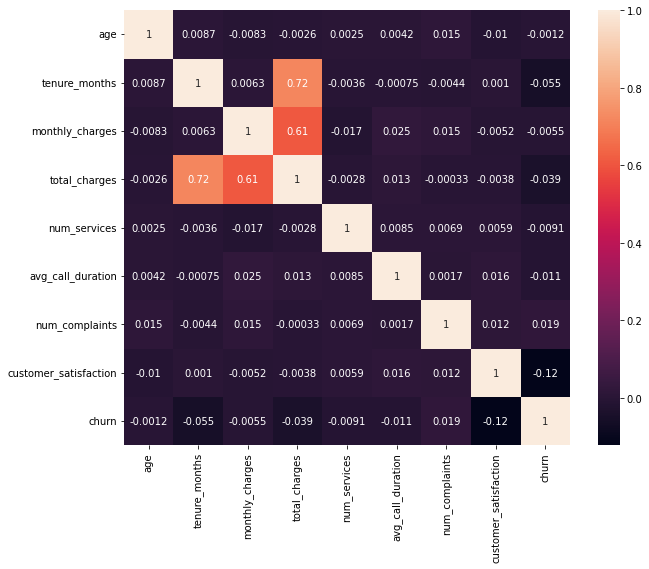

In [8]:
plt.figure(figsize=(10,8))
sns.heatmap(numerical_df.corr(),annot=True)
#sns.heatmap(df.corr(),annot=True)

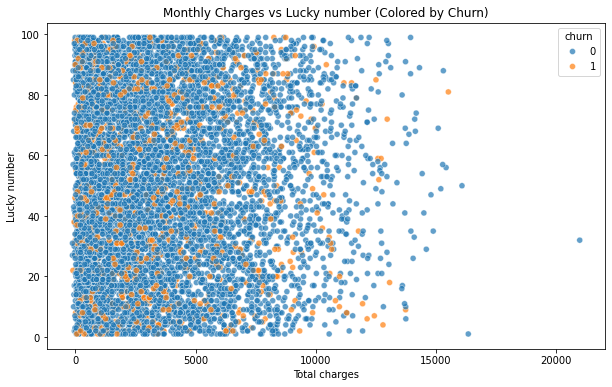

In [9]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x="total_charges", y="lucky_number", hue="churn", alpha=0.7)

plt.title("Monthly Charges vs Lucky number (Colored by Churn)")
plt.xlabel("Total charges")
plt.ylabel("Lucky number")
plt.show()

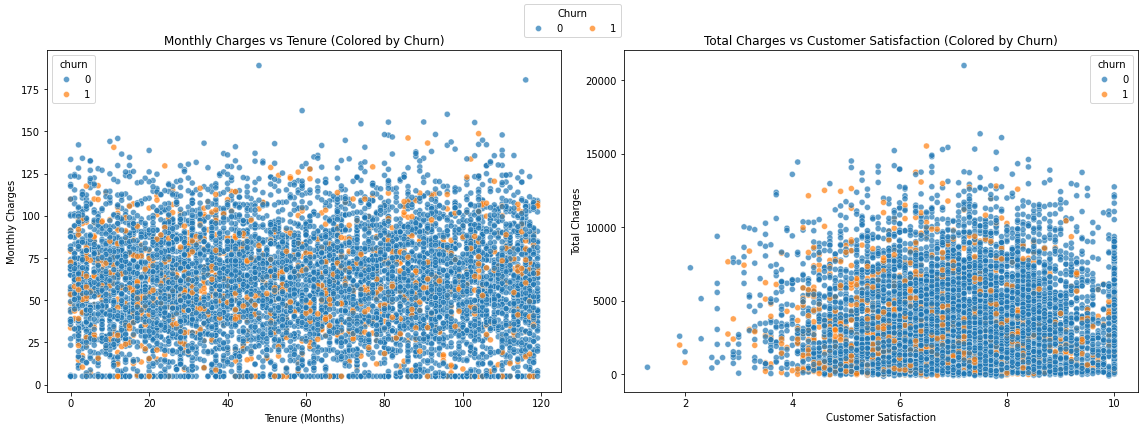

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(16,6))  # 1 row, 2 columns

# Plot 1: Monthly Charges vs Tenure
sns.scatterplot(
    data=df, x="tenure_months", y="monthly_charges",
    hue="churn", alpha=0.7, ax=axes[0]
)
axes[0].set_title("Monthly Charges vs Tenure (Colored by Churn)")
axes[0].set_xlabel("Tenure (Months)")
axes[0].set_ylabel("Monthly Charges")

# Plot 2: Total Charges vs Customer Satisfaction
sns.scatterplot(
    data=df, x="customer_satisfaction", y="total_charges",
    hue="churn", alpha=0.7, ax=axes[1]
)
axes[1].set_title("Total Charges vs Customer Satisfaction (Colored by Churn)")
axes[1].set_xlabel("Customer Satisfaction")
axes[1].set_ylabel("Total Charges")

# Move legend outside to avoid overlap
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, labels, title="Churn", loc="upper center", ncol=2)

plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

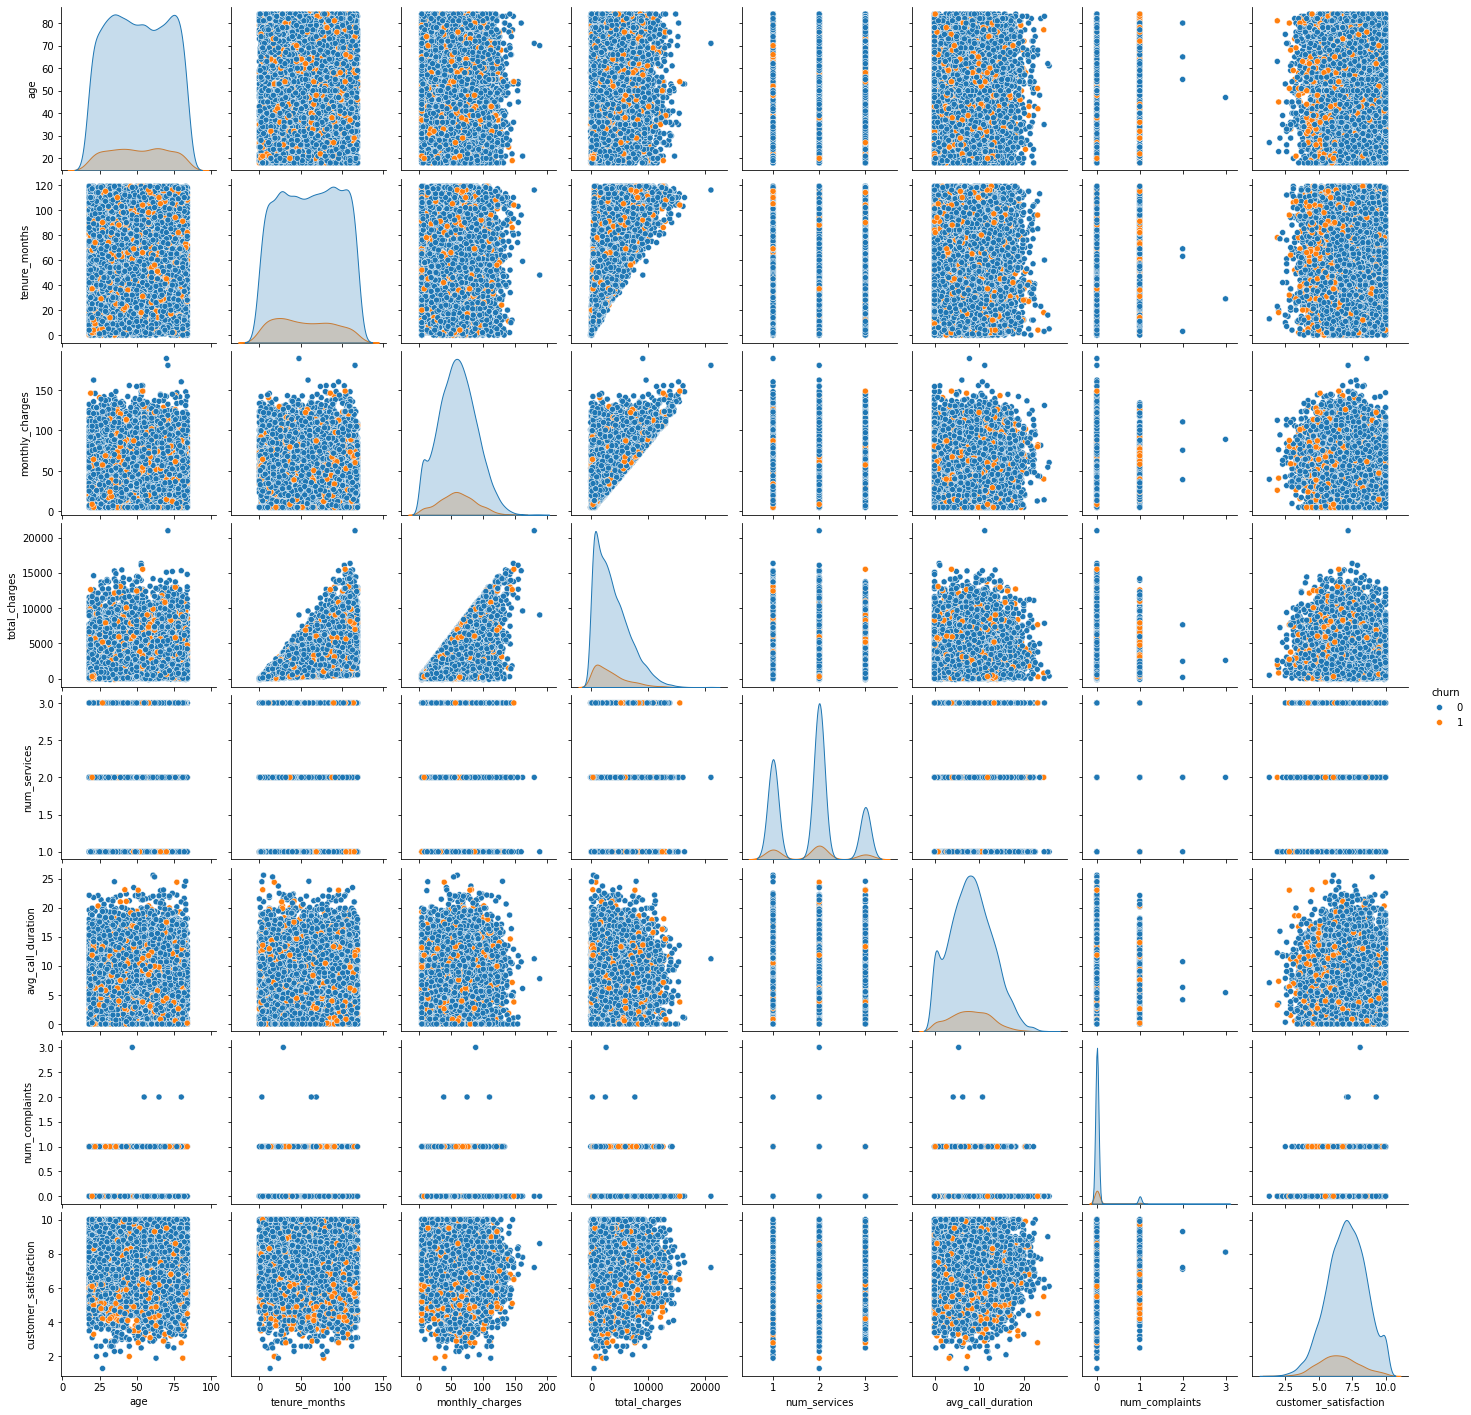

In [11]:
sns.pairplot(data=numerical_df, hue="churn")

### Quick look to categorical variables
We apply the chi-square test to check wether the categorical variables are independant or not

Axes(0.125,0.125;0.62x0.755)


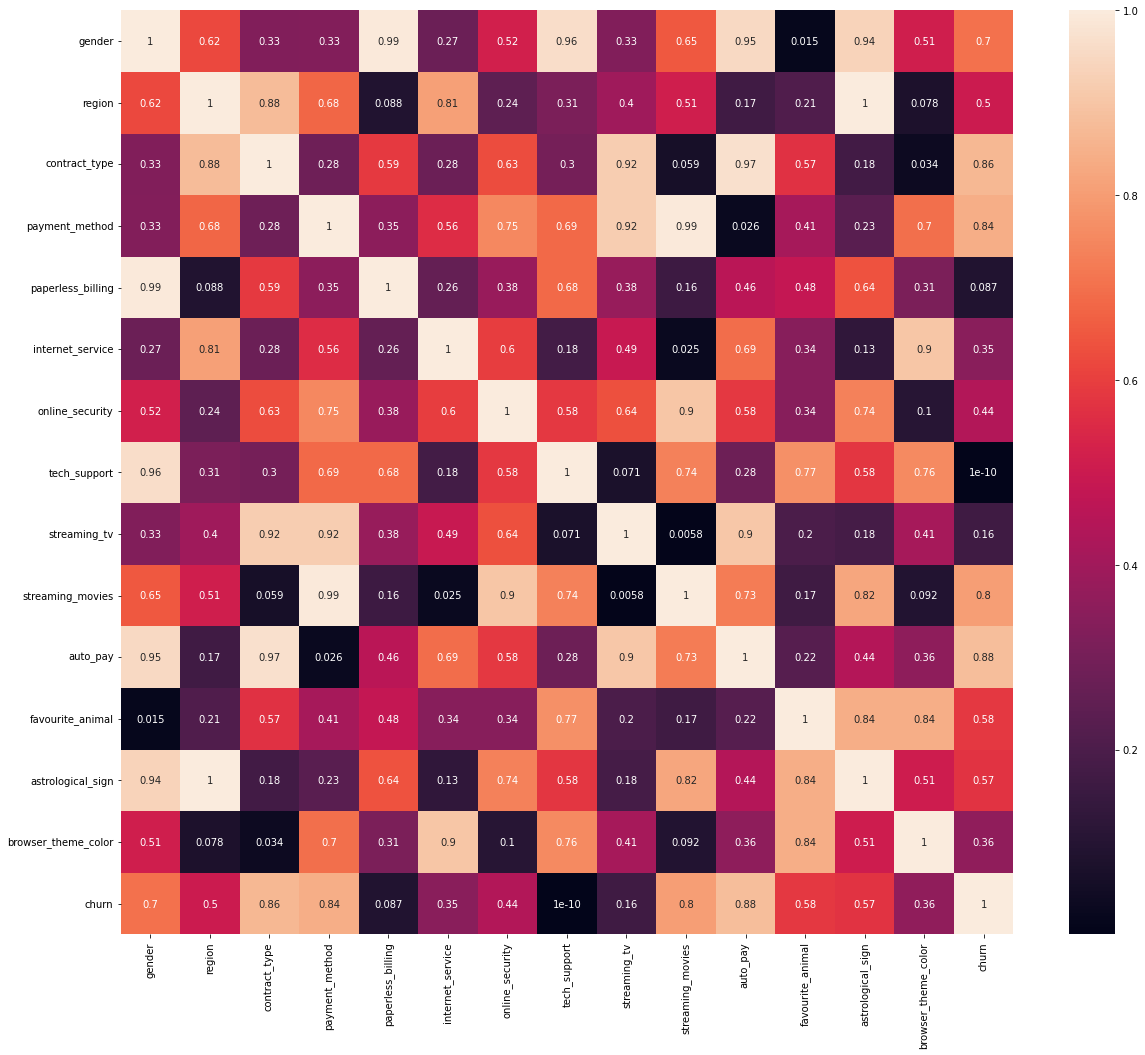

In [12]:
def chi2_pvalue_matrix(df: pd.DataFrame) -> pd.DataFrame:
    """
    Prend un DataFrame de variables catégorielles et renvoie
    une matrice (DataFrame) des p-values du test du Chi2
    entre chaque paire de colonnes.
    """
    cols = df.columns
    n = len(cols)
    
    # matrice vide
    pval_matrix = pd.DataFrame(index=cols, columns=cols, dtype=float)
    
    # boucle sur les paires de colonnes
    for i in range(n):
        for j in range(n):
            if i == j:
                pval_matrix.iloc[i, j] = 1.0  # diagonale = 1
            else:
                # tableau de contingence
                contingency_table = pd.crosstab(df[cols[i]], df[cols[j]])
                try:
                    chi2, p, dof, expected = chi2_contingency(contingency_table)
                    pval_matrix.iloc[i, j] = p
                except Exception:
                    pval_matrix.iloc[i, j] = None  # au cas où une erreur
    
    return pval_matrix

plt.figure(figsize=(20,17))
categorical_data = categorical_variables+["churn"]
print(sns.heatmap(chi2_pvalue_matrix(df[categorical_data]),annot=True))

In [13]:
v = df["tech_support"] == df['churn']
v.value_counts()


True     5279
False    2721
Name: count, dtype: int64

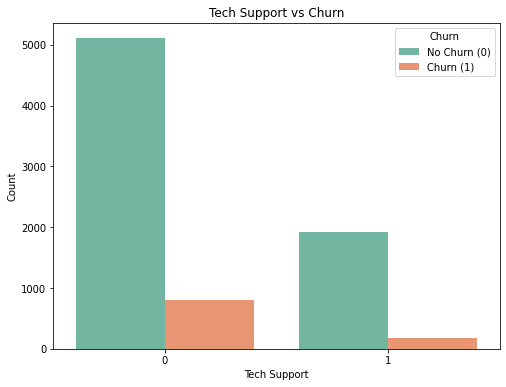

In [14]:
plt.figure(figsize=(8,6))
sns.countplot(data=df, x="tech_support", hue="churn", palette="Set2")

plt.title("Tech Support vs Churn")
plt.xlabel("Tech Support")
plt.ylabel("Count")
plt.legend(title="Churn", labels=["No Churn (0)", "Churn (1)"])
plt.show()

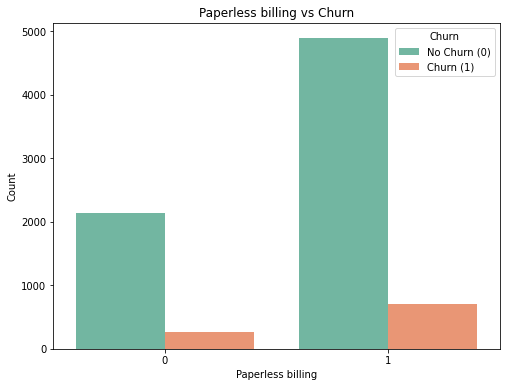

In [15]:
plt.figure(figsize=(8,6))
sns.countplot(data=df, x="paperless_billing", hue="churn", palette="Set2")

plt.title("Paperless billing vs Churn")
plt.xlabel("Paperless billing")
plt.ylabel("Count")
plt.legend(title="Churn", labels=["No Churn (0)", "Churn (1)"])
plt.show()

<BarContainer object of 2 artists>

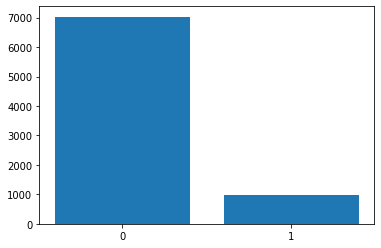

In [16]:
plt.bar(['0','1'],df["churn"].value_counts())

### Complementary exploratory analysis

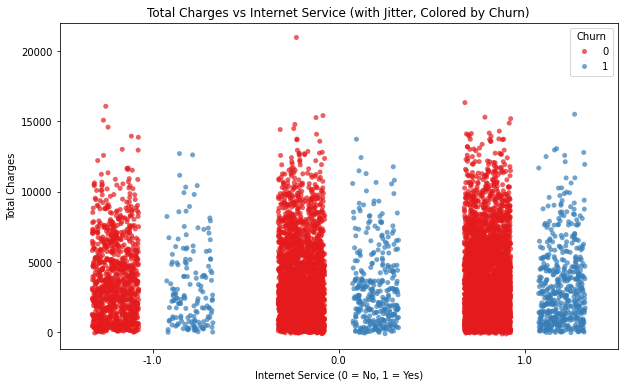

In [17]:
plt.figure(figsize=(10,6))
sns.stripplot(
    data=df,
    x="internet_service",
    y="total_charges",
    hue="churn",
    jitter=0.25,   # amount of jitter
    alpha=0.7,
    dodge=True,    # separate churn categories slightly
    palette="Set1"
)

plt.title("Total Charges vs Internet Service (with Jitter, Colored by Churn)")
plt.xlabel("Internet Service (0 = No, 1 = Yes)")
plt.ylabel("Total Charges")
plt.legend(title="Churn")
plt.show()

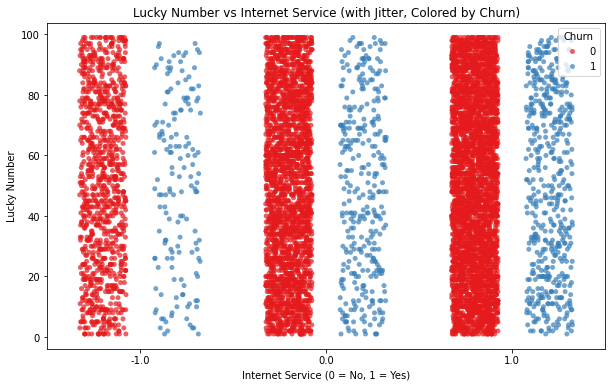

In [18]:
plt.figure(figsize=(10,6))
sns.stripplot(
    data=df,
    x="internet_service",
    y="lucky_number",
    hue="churn",
    jitter=0.25,   # amount of jitter
    alpha=0.7,
    dodge=True,    # separate churn categories slightly
    palette="Set1"
)

plt.title("Lucky Number vs Internet Service (with Jitter, Colored by Churn)")
plt.xlabel("Internet Service (0 = No, 1 = Yes)")
plt.ylabel("Lucky Number")
plt.legend(title="Churn")
plt.show()

<Axes: xlabel='customer_satisfaction'>

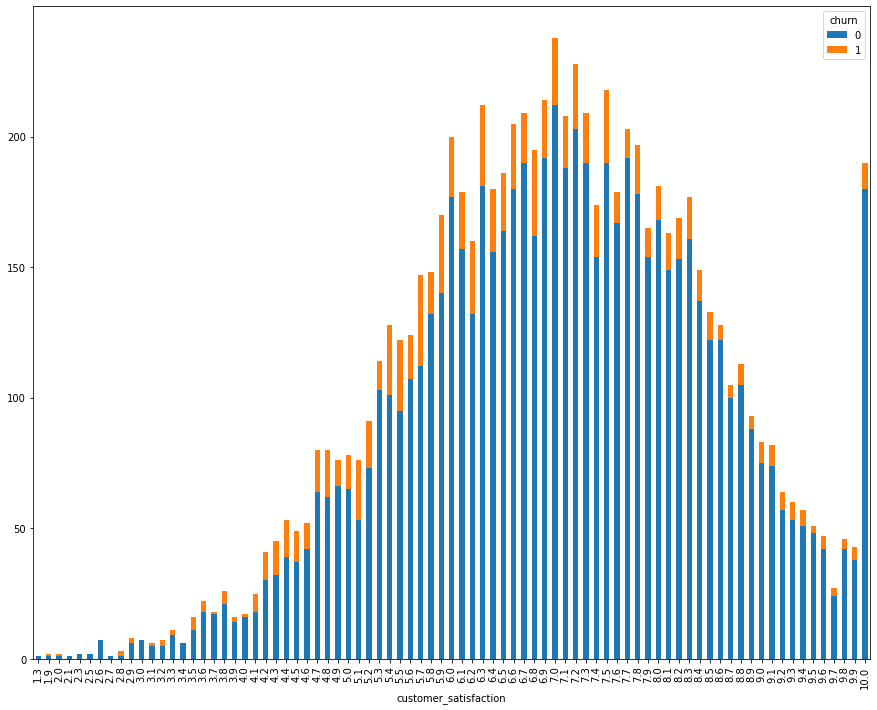

In [19]:
plot_data = df.groupby(["customer_satisfaction", "churn"]).size().unstack(fill_value=0)

# Plot stacked bar
plot_data.plot(kind="bar", stacked=True,figsize=(15,12))

<Axes: xlabel='tenure_months'>

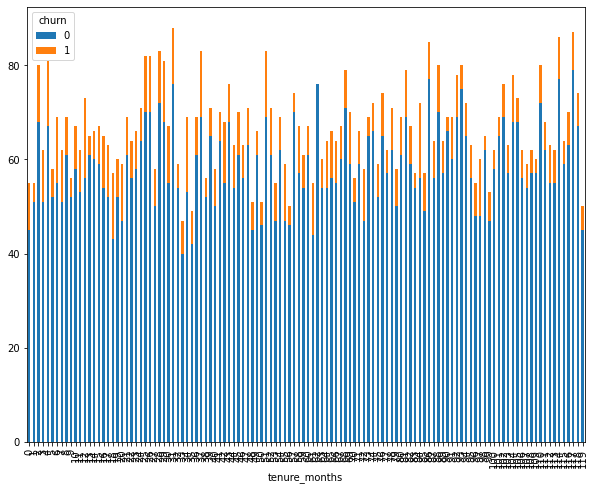

In [20]:
plot_data = df.groupby(["tenure_months", "churn"]).size().unstack(fill_value=0)
# Plot stacked bar
plot_data.plot(kind="bar", stacked=True,figsize=(10,8))

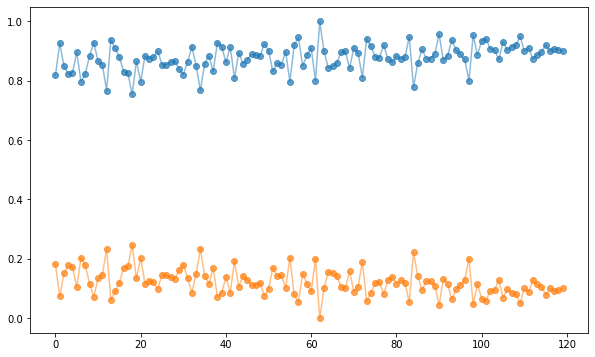

In [21]:
# Get proportions per month
proportions = plot_data.div(plot_data.sum(axis=1), axis=0)

plt.figure(figsize=(10,6))

# Scatter (or line) plot of churn=0 and churn=1 proportions by tenure month
plt.scatter(proportions.index, proportions[0], label="Churn = 0", alpha=0.7)
plt.scatter(proportions.index, proportions[1], label="Churn = 1", alpha=0.7)

# Optional: connect points with lines
plt.plot(proportions.index, proportions[0], alpha=0.5)
plt.plot(proportions.index, proportions[1], alpha=0.5)


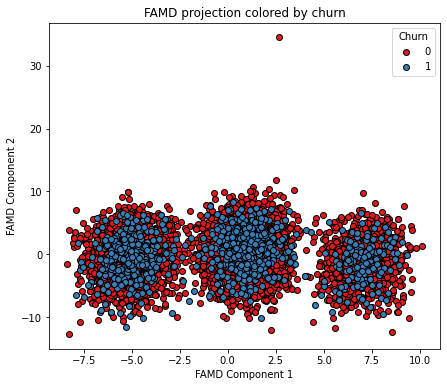

In [22]:
import prince
from sklearn.preprocessing import StandardScaler
df_for_acp = df.drop(columns="churn")
famd = prince.FAMD(n_components=df_for_acp.shape[1], random_state=12)
famd = famd.fit(df_for_acp)

# Transform data into principal components
df_transformed = famd.transform(df_for_acp)

classes = df['churn'].unique()
colors = plt.cm.Set1(range(len(classes)))  # pick a colormap

plt.figure(figsize=(7,6))
for cls, color in zip(classes, colors):
    mask = df['churn'] == cls
    plt.scatter(df_transformed.loc[mask, 0],
                df_transformed.loc[mask, 1],
                label=str(cls),
                c=[color], edgecolor="k")

plt.xlabel("FAMD Component 1")
plt.ylabel("FAMD Component 2")
plt.title("FAMD projection colored by churn")
plt.legend(title="Churn")
plt.show()

In [23]:
eigenvalues = famd.eigenvalues_

# Explained variance ratio (inertia per component / total inertia)
explained_var_ratio = eigenvalues / eigenvalues.sum()

print("Eigenvalues:", eigenvalues)
print("Explained variance ratio:", explained_var_ratio)
var_contrib = famd.column_contributions_

for new_axis in range(2):
    factor1_contrib = famd.column_contributions_[new_axis]
    factor1_contrib_percent = factor1_contrib / factor1_contrib.sum() 
    print(factor1_contrib_percent)

Eigenvalues: [18.00653499 11.17050452 11.09830395 11.07544161 10.9915332  10.91176333
 10.87841154 10.8252811  10.78948788 10.70398273 10.65001818 10.63702519
 10.56189501 10.53589845 10.4658574  10.40845952 10.36961924 10.27918433
 10.26494521 10.16048734 10.10339383 10.05521189 10.04457647]
Explained variance ratio: [0.07174267 0.04450616 0.0442185  0.04412741 0.04379309 0.04347527
 0.04334239 0.0431307  0.04298809 0.04264742 0.04243241 0.04238064
 0.04208131 0.04197773 0.04169867 0.04146998 0.04131523 0.04095491
 0.04089818 0.04048199 0.04025452 0.04006255 0.04002018]
variable
monthly_charges          5.181849e-05
total_charges            3.523809e-05
internet_service         2.126528e-04
avg_call_duration        7.419182e-05
customer_satisfaction    4.030353e-05
age                      1.648118e-02
astrological_sign        2.723326e-03
auto_pay                 1.111379e-04
browser_theme_color      1.319882e-03
contract_type            2.809006e-04
favourite_animal         1.920162

### Preparing the data for analysis

In [24]:

from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

X = df.drop(columns="churn")
y = df['churn']


#ros = RandomUnderSampler(random_state=0) #oversampling the data
#X, y = ros.fit_resample(X, y)

x_train, x_test, y_train, y_test = train_test_split(X, y ,random_state=44, test_size=0.20, shuffle=True)

#sme = SMOTEENN(random_state=42)
#x_train, y_train = sme.fit_resample(x_train, y_train)

In [25]:
sm = SMOTENC(random_state=42, categorical_features=categorical_variables)
x_train, y_train = sm.fit_resample(x_train, y_train)

In [26]:
print(X.shape)
print(y.value_counts())
print(y_train.value_counts())

(8000, 23)
churn
0    7031
1     969
Name: count, dtype: int64
churn
0    5607
1    5607
Name: count, dtype: int64


### Backward selection

In [27]:
def processSubset(model, metrics, X, y, y_type, metric_types, feature_set, nb_folds, shuffle, random_state):
    """
    Fit the model once per fold for a given feature_set and evaluate all metrics.
    """
    features = list(feature_set)

    if y_type == "continuous":
        cv = KFold(n_splits=nb_folds, shuffle=shuffle, random_state=random_state)
    elif y_type == "categorical":
        cv = StratifiedKFold(n_splits=nb_folds, shuffle=shuffle, random_state=random_state)

    # turn single metric into a list
    if not isinstance(metrics, (list, tuple)):
        metrics = [metrics]
        metric_types = [metric_types]

    # Store scores for each metric
    scores_dict = {m.__name__ if hasattr(m, "__name__") else str(m): [] for m in metrics}

    for train_index, test_index in cv.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        p_model = model.fit(X_train[features], y_train)

        for metric, metric_type in zip(metrics, metric_types):
            m_name = metric.__name__ if hasattr(metric, "__name__") else str(metric)

            if metric_type == "error":
                y_pred = p_model.predict(X_test[features])
                scores_dict[m_name].append(metric(y_test, y_pred))

            elif metric_type == "probability_roc":
                prob = p_model.predict_proba(X_test[features])
                scores_dict[m_name].append(metric(y_test, prob[:, 1]))

            elif metric_type == "probability-likelihood":
                prob = p_model.predict_proba(X_train[features])
                scores_dict[m_name].append(metric(X_train, y_train, prob))

    # Create one result per metric
    results = []
    for metric in metrics:
        m_name = metric.__name__ if hasattr(metric, "__name__") else str(metric)
        results.append({
            "model": p_model,
            "number_of_variables": len(features),
            "selected_featured": features,
            "metric": m_name,
            "score": sum(scores_dict[m_name]) / len(scores_dict[m_name])
        })

    return results


def select_variables_for_backward(model, metrics, X, y, y_type, metrics_goal, metric_types, nb_folds, shuffle, random_state):
    predictors = X.columns
    best_model = pd.DataFrame(columns=["model", "number_of_variables", "selected_featured", "metric", "score"])
    nov = len(predictors) + 1

    # turn single metrics into list
    if not isinstance(metrics, (list, tuple)):
        metrics = [metrics]
        metrics_goal = [metrics_goal]
        metric_types = [metric_types]

    while nov > 1:
        results = []
        tic = time.time()

        for feature_set in itertools.combinations(predictors, nov - 1):
            results.extend(processSubset(model, metrics, X, y, y_type, metric_types, feature_set, nb_folds, shuffle, random_state))

        result_df = pd.DataFrame(results)

        # Choose best subset for each metric
        for metric, metric_goal in zip(metrics, metrics_goal):
            m_name = metric.__name__ if hasattr(metric, "__name__") else str(metric)
            metric_df = result_df[result_df["metric"] == m_name]

            if metric_goal == "min":
                best_model.loc[best_model.shape[0]] = metric_df.iloc[metric_df['score'].argmin()]
            elif metric_goal == "max":
                best_model.loc[best_model.shape[0]] = metric_df.iloc[metric_df['score'].argmax()]

        toc = time.time()

        if nov - 1 == len(X.columns):
            time_estimated = ((nov - 1) * nov / 2) * float(toc - tic)
            print(f"estimated time for running : {time_estimated//60} min {time_estimated%60} seconds")

        print("Processed", int(result_df.shape[0]/len(metrics)), "models on", nov - 1, "variables in", (toc - tic), "seconds.")

        # Update predictors based on the *last chosen metric*
        predictors = best_model.iloc[-1]["selected_featured"]
        nov = len(predictors)

    return best_model


def backward(model, metrics, X, y, y_type="continuous", metrics_goal="min", metric_types="error",
              nb_folds=10, shuffle=False, random_state=None):
    """
    Backward selection wrapper. Accepts single or multiple metrics.
    """
    assert isinstance(X, pd.Series) or isinstance(X, pd.DataFrame), \
        "X must be pandas.Series or pandas.DataFrames."
    assert (isinstance(y, pd.Series) or (isinstance(y, pd.DataFrame) and y.shape[1] == 1)), \
        "y must be pandas.Series or single-column pandas.DataFrames."

    best = select_variables_for_backward(model, metrics, X, y, y_type,
                                         metrics_goal, metric_types,
                                         nb_folds, shuffle, random_state)
    return best

# KNN

In [28]:
from sklearn.preprocessing import StandardScaler

# Variables catégorielles (déjà encodées)
categorical_variables = [
    "gender", "region", "contract_type", "payment_method", "paperless_billing",
    "internet_service", "online_security", "tech_support", "streaming_tv", "streaming_movies",
    "auto_pay", "favourite_animal", "astrological_sign", "browser_theme_color"
]

# Variables continues à scaler
numerical_variables = [col for col in X.columns if col not in categorical_variables + ["churn"]]

# Scaling uniquement sur les numériques
scaler = StandardScaler()
X_train_scaled = x_train.copy()
X_test_scaled = x_test.copy()

X_train_scaled[numerical_variables] = scaler.fit_transform(x_train[numerical_variables])
X_test_scaled[numerical_variables] = scaler.transform(x_test[numerical_variables])

k=1, AUC moyen=0.7370
k=3, AUC moyen=0.8183
k=5, AUC moyen=0.8325
k=7, AUC moyen=0.8349
k=9, AUC moyen=0.8354
k=11, AUC moyen=0.8358
k=13, AUC moyen=0.8352
k=15, AUC moyen=0.8357
k=17, AUC moyen=0.8343
k=19, AUC moyen=0.8321
k=21, AUC moyen=0.8296
k=23, AUC moyen=0.8270
k=25, AUC moyen=0.8259
k=27, AUC moyen=0.8246
k=29, AUC moyen=0.8235
k=31, AUC moyen=0.8225
k=33, AUC moyen=0.8213
k=35, AUC moyen=0.8186
k=37, AUC moyen=0.8175
k=39, AUC moyen=0.8158
k=41, AUC moyen=0.8150
k=43, AUC moyen=0.8137
k=45, AUC moyen=0.8121
k=47, AUC moyen=0.8108
k=49, AUC moyen=0.8103
k=51, AUC moyen=0.8089
k=53, AUC moyen=0.8079
k=55, AUC moyen=0.8071
k=57, AUC moyen=0.8070
k=59, AUC moyen=0.8061
k=61, AUC moyen=0.8056
k=63, AUC moyen=0.8051
k=65, AUC moyen=0.8050
k=67, AUC moyen=0.8043
k=69, AUC moyen=0.8040
k=71, AUC moyen=0.8035
k=73, AUC moyen=0.8027
k=75, AUC moyen=0.8021
k=77, AUC moyen=0.8021
k=79, AUC moyen=0.8017
k=81, AUC moyen=0.8015
k=83, AUC moyen=0.8016
k=85, AUC moyen=0.8006
k=87, AUC moyen=

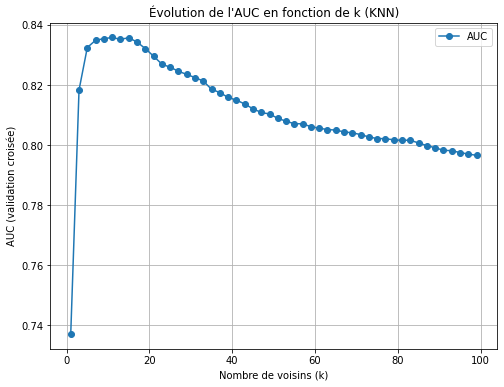

k  AUC_mean
0    1  0.737013
1    3  0.818302
2    5  0.832477
3    7  0.834893
4    9  0.835415
5   11  0.835823
6   13  0.835201
7   15  0.835723
8   17  0.834318
9   19  0.832114
10  21  0.829592
11  23  0.826952
12  25  0.825893
13  27  0.824592
14  29  0.823492
15  31  0.822478
16  33  0.821312
17  35  0.818557
18  37  0.817471
19  39  0.815838
20  41  0.814961
21  43  0.813654
22  45  0.812059
23  47  0.810828
24  49  0.810320
25  51  0.808882
26  53  0.807910
27  55  0.807091
28  57  0.807037
29  59  0.806099
30  61  0.805601
31  63  0.805114
32  65  0.804977
33  67  0.804343
34  69  0.804049
35  71  0.803459
36  73  0.802666
37  75  0.802129
38  77  0.802098
39  79  0.801696
40  81  0.801538
41  83  0.801592
42  85  0.800640
43  87  0.799802
44  89  0.799044
45  91  0.798241
46  93  0.798075
47  95  0.797474
48  97  0.796966
49  99  0.796542

In [29]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import matplotlib.pyplot as plt

# Range of k values
k_values = list(range(1, 101, 2))

auc_means = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring="roc_auc")
    auc_means.append(scores.mean())
    print(f"k={k}, AUC moyen={scores.mean():.4f}")

# Create DataFrame
df_k_auc = pd.DataFrame({"k": k_values, "AUC_mean": auc_means})

# Plot
plt.figure(figsize=(8,6))
plt.plot(df_k_auc["k"], df_k_auc["AUC_mean"], '-o', label="AUC")
plt.xlabel("Nombre de voisins (k)")
plt.ylabel("AUC (validation croisée)")
plt.title("Évolution de l'AUC en fonction de k (KNN)")
plt.legend()
plt.grid(True)
plt.show()

display(df_k_auc)

In [30]:
# Ligne avec le meilleur AUC_mean
best_row = df_k_auc.loc[df_k_auc['AUC_mean'].idxmax()]

# Valeur de k corrspondant 
k = best_row['k']

print(k)

11.0


In [31]:
k = int(k)

KNN (k=7, weights=uniform)
Classification report :
               precision    recall  f1-score   support

           0       0.91      0.50      0.64      1424
           1       0.13      0.58      0.21       176

    accuracy                           0.51      1600
   macro avg       0.52      0.54      0.43      1600
weighted avg       0.82      0.51      0.60      1600

AUC : 0.5631124712717058
Matrice de confusion :
 [[713 711]
 [ 74 102]]


KNN (k=7, weights=distance)
Classification report :
               precision    recall  f1-score   support

           0       0.91      0.50      0.64      1424
           1       0.13      0.58      0.21       176

    accuracy                           0.51      1600
   macro avg       0.52      0.54      0.43      1600
weighted avg       0.82      0.51      0.60      1600

AUC : 0.5636072363381002
Matrice de confusion :
 [[712 712]
 [ 74 102]]




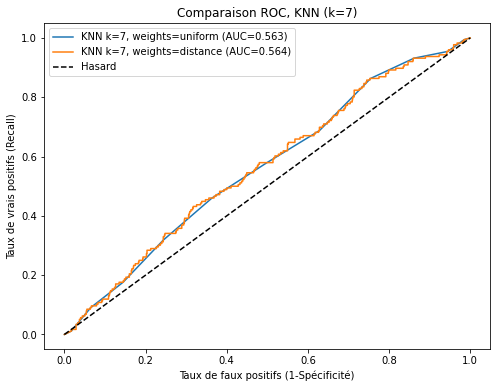

In [32]:
from sklearn.metrics import roc_auc_score, classification_report, roc_curve, auc, confusion_matrix

results_knn_weights = {}

for w in ["uniform", "distance"]:
    knn = KNeighborsClassifier(n_neighbors=k, weights=w)
    knn.fit(X_train_scaled, y_train)  
    
    # Test
    y_pred = knn.predict(X_test_scaled)
    y_prob = knn.predict_proba(X_test_scaled)[:, 1]
    
    results_knn_weights[w] = {
        "y_pred": y_pred,
        "y_prob": y_prob,
        "report": classification_report(y_test, y_pred, output_dict=True),
        "auc": roc_auc_score(y_test, y_prob),
        "conf_matrix": confusion_matrix(y_test, y_pred)
    }
    
    print(f"KNN (k=7, weights={w})")
    print("Classification report :\n", classification_report(y_test, y_pred))
    print("AUC :", roc_auc_score(y_test, y_prob))
    print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred))
    print("\n")

# ROC
plt.figure(figsize=(8,6))
for w in results_knn_weights.keys():
    fpr, tpr, _ = roc_curve(y_test, results_knn_weights[w]["y_prob"])
    plt.plot(fpr, tpr, label=f"KNN k=7, weights={w} (AUC={results_knn_weights[w]['auc']:.3f})")

plt.plot([0,1],[0,1],'k--',label="Hasard")
plt.xlabel("Taux de faux positifs (1-Spécificité)")
plt.ylabel("Taux de vrais positifs (Recall)")
plt.title("Comparaison ROC, KNN (k=7)")
plt.legend()
plt.show()


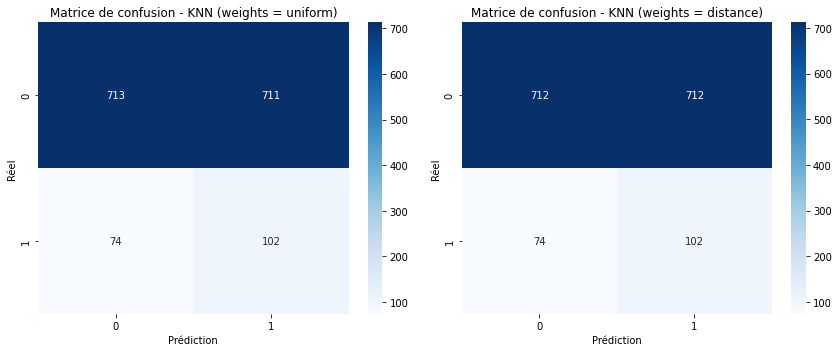

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for ax, w in zip(axes, results_knn_weights.keys()):
    cm = results_knn_weights[w]["conf_matrix"]
    
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_title(f"Matrice de confusion - KNN (weights = {w})")
    ax.set_xlabel("Prédiction")
    ax.set_ylabel("Réel")

plt.tight_layout()
plt.show()

### Applying bagging to decision tree


The time needed to run that chunk is quite long, if it is needed to run it faster then limiting the number of estimator_range is a good choice, like using only 10, 15 and 20.

In [34]:
estimator_range = [5,10,15,20,25]

models = []
scores = []

df_score = pd.DataFrame(columns=["model", "estimator_range", "number_of_variables", "selected_featured", "metric", "score"])

for n_estimators in estimator_range:
    model = BaggingClassifier(n_estimators = n_estimators, oob_score=True, random_state = 22)
    #df_backward = backward(model, roc_auc_score, X, y, y_type="categorical", metrics_goal="max", metrics_type="probability_roc",
    #          nb_folds=10, shuffle=False, random_state=None)
    df_backward = backward(model, [accuracy_score, roc_auc_score], x_train, y_train, y_type="categorical", metrics_goal=["max","max"], metric_types=["error","probability_roc"],
              nb_folds=5, shuffle=False, random_state=None)
    df_backward['estimator_range'] = n_estimators
    df_score = pd.concat([df_score,df_backward], ignore_index=True)
    print(df_score)

df_score.to_csv('bagging_results.csv', index=False,header=True)


estimated time for running : 8.0 min 16.092927932739258 seconds
Processed 1 models on 23 variables in 1.797438144683838 seconds.
Processed 23 models on 22 variables in 39.61103391647339 seconds.
Processed 22 models on 21 variables in 33.86035871505737 seconds.
Processed 21 models on 20 variables in 27.158327341079712 seconds.
Processed 20 models on 19 variables in 22.747127294540405 seconds.
Processed 19 models on 18 variables in 26.666640758514404 seconds.
Processed 18 models on 17 variables in 18.838621616363525 seconds.
Processed 17 models on 16 variables in 14.584969997406006 seconds.
Processed 16 models on 15 variables in 10.378230810165405 seconds.
Processed 15 models on 14 variables in 9.032825946807861 seconds.
Processed 14 models on 13 variables in 8.020506381988525 seconds.
Processed 13 models on 12 variables in 7.136904001235962 seconds.
Processed 12 models on 11 variables in 6.350972652435303 seconds.
Processed 11 models on 10 variables in 5.6549012660980225 seconds.
Proces

### Display result for our bagging with decision tree

We can see that our model is badly performing with an accuracy score close to 0.5

In [35]:
df_result = pd.read_csv("bagging_results.csv")
best = df_result.loc[df_result['score'].idxmax()]
print(best["selected_featured"])

['gender', 'region', 'total_charges', 'paperless_billing', 'internet_service', 'online_security', 'tech_support', 'streaming_tv', 'streaming_movies', 'num_complaints', 'auto_pay', 'favourite_animal', 'browser_theme_color']


In [36]:
print(df_result.to_string())

                                                                   model  estimator_range  number_of_variables                                                                                                                                                                                                                                                                                                                                                                                                selected_featured          metric     score
0     BaggingClassifier(n_estimators=5, oob_score=True, random_state=22)                5                   23  ['age', 'gender', 'region', 'tenure_months', 'contract_type', 'monthly_charges', 'total_charges', 'payment_method', 'paperless_billing', 'internet_service', 'online_security', 'tech_support', 'streaming_tv', 'streaming_movies', 'num_services', 'avg_call_duration', 'num_complaints', 'customer_satisfaction', 'auto_pay', 'favourite_animal', 'astrologi

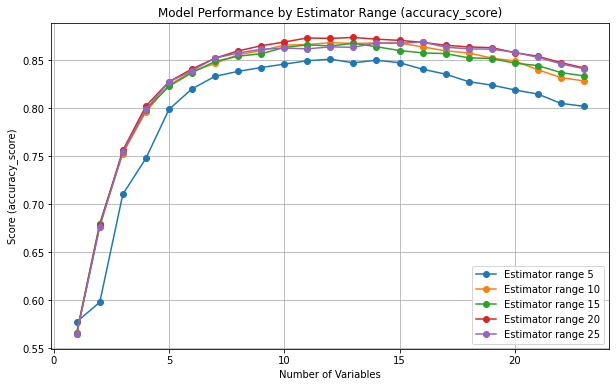

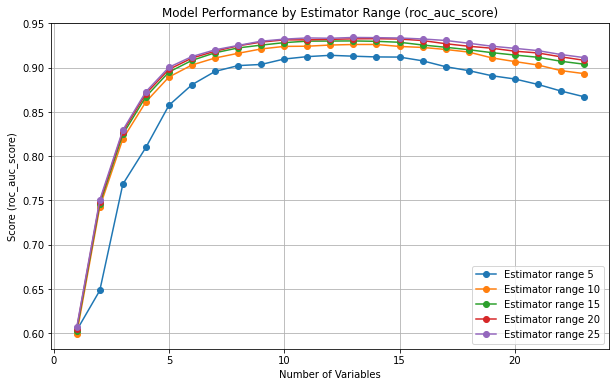

In [37]:
for metric_name, metric_group in df_result.groupby("metric"):
    plt.figure(figsize=(10,6))

    # Inside each metric, loop over estimator_range
    for est_range, group in metric_group.groupby("estimator_range"):
        group_sorted = group.sort_values("number_of_variables")
        plt.plot(group_sorted["number_of_variables"], 
                 group_sorted["score"], 
                 marker="o", 
                 label=f"Estimator range {est_range}")

    plt.xlabel("Number of Variables")
    plt.ylabel(f"Score ({metric_name})")
    plt.title(f"Model Performance by Estimator Range ({metric_name})")
    plt.legend()
    plt.grid(True)
    plt.show()

In [66]:
df_selected_model = df_result[df_result["number_of_variables"] == 13]
for i in range(4):
    print(df_selected_model['selected_featured'].iloc[i])

['gender', 'region', 'total_charges', 'internet_service', 'online_security', 'tech_support', 'streaming_tv', 'streaming_movies', 'num_services', 'num_complaints', 'auto_pay', 'favourite_animal', 'browser_theme_color']
['gender', 'region', 'total_charges', 'paperless_billing', 'online_security', 'tech_support', 'streaming_tv', 'streaming_movies', 'num_services', 'num_complaints', 'auto_pay', 'favourite_animal', 'browser_theme_color']
['gender', 'region', 'total_charges', 'internet_service', 'online_security', 'tech_support', 'streaming_tv', 'streaming_movies', 'num_services', 'num_complaints', 'auto_pay', 'favourite_animal', 'browser_theme_color']
['gender', 'region', 'total_charges', 'paperless_billing', 'online_security', 'tech_support', 'streaming_tv', 'streaming_movies', 'num_services', 'num_complaints', 'auto_pay', 'favourite_animal', 'browser_theme_color']


## Applying random forest 

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

rf = RandomForestClassifier(n_estimators=10, random_state=42, n_jobs=-1)
df_backward_rf = backward(
    model=rf,
    metrics=roc_auc_score,
    X=x_train,
    y=y_train,
    y_type="categorical",
    metrics_goal="max",
    metric_types="probability_roc",
    nb_folds=10,
    shuffle=True,
    random_state=42
)

estimated time for running : 6.0 min 12.26220417022705 seconds
Processed 1 models on 23 variables in 1.34877610206604 seconds.
Processed 23 models on 22 variables in 29.320536136627197 seconds.
Processed 22 models on 21 variables in 28.900795698165894 seconds.
Processed 21 models on 20 variables in 28.11701250076294 seconds.
Processed 20 models on 19 variables in 26.074883222579956 seconds.
Processed 19 models on 18 variables in 24.20029306411743 seconds.
Processed 18 models on 17 variables in 20.927058696746826 seconds.
Processed 17 models on 16 variables in 18.825451374053955 seconds.
Processed 16 models on 15 variables in 17.8452889919281 seconds.
Processed 15 models on 14 variables in 14.180870056152344 seconds.
Processed 14 models on 13 variables in 13.053924322128296 seconds.
Processed 13 models on 12 variables in 12.464863777160645 seconds.
Processed 12 models on 11 variables in 11.216409921646118 seconds.
Processed 11 models on 10 variables in 10.779375553131104 seconds.
Proces

In [40]:
best_row_rf = df_backward_rf.loc[df_backward_rf['score'].idxmax()]
best_features_rf = best_row_rf['selected_featured']

print("Meilleur modèle Random Forest")
print("Nombre de variables :", len(best_features_rf))
print("AUC :", best_row_rf['score'])
print("Variables sélectionnées :", best_features_rf)

Meilleur modèle Random Forest
Nombre de variables : 14
AUC : 0.9220574586583945
Variables sélectionnées : ['gender', 'region', 'total_charges', 'paperless_billing', 'internet_service', 'online_security', 'tech_support', 'streaming_tv', 'streaming_movies', 'num_services', 'num_complaints', 'auto_pay', 'favourite_animal', 'browser_theme_color']


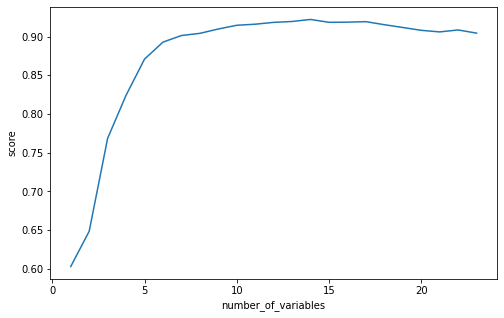

In [41]:
plt.figure(figsize=(8,5))
sns.lineplot(data=df, x=df_backward_rf['number_of_variables'], y=df_backward_rf['score'])
plt.show()

In [42]:
from sklearn.metrics import roc_auc_score

X_train_best = x_train[best_features_rf]
X_test_best = x_test[best_features_rf]

rf_final = RandomForestClassifier(
    n_estimators=10,
    random_state=42,
    n_jobs=-1
)

# TRain
rf_final.fit(X_train_best, y_train)

auc_scores = cross_val_score(
    rf_final, X_test_best, y_test,
    cv=5,
    scoring='roc_auc'
)

# Test
y_pred_proba = rf_final.predict_proba(X_test_best[best_features_rf])[:, 1]


auc_test = roc_auc_score(y_test, y_pred_proba)
print(auc_test.mean())

0.5135202534473953


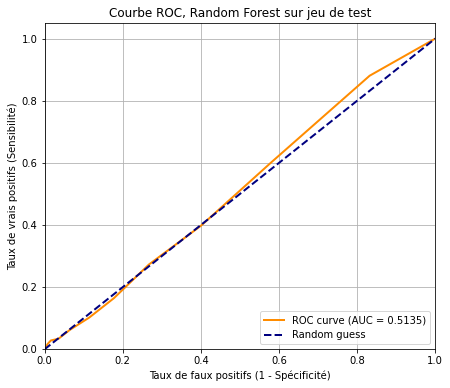

In [43]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Tracé de la courbe
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random guess')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs (1 - Spécificité)')
plt.ylabel('Taux de vrais positifs (Sensibilité)')
plt.title('Courbe ROC, Random Forest sur jeu de test')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


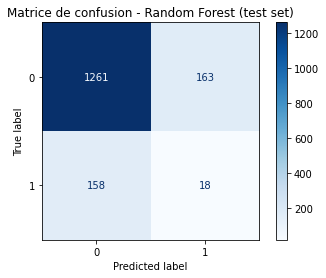

In [44]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = rf_final.predict(X_test_best)

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["0", "1"])
disp.plot(cmap="Blues", values_format='d')
plt.title("Matrice de confusion - Random Forest (test set)")
plt.show()


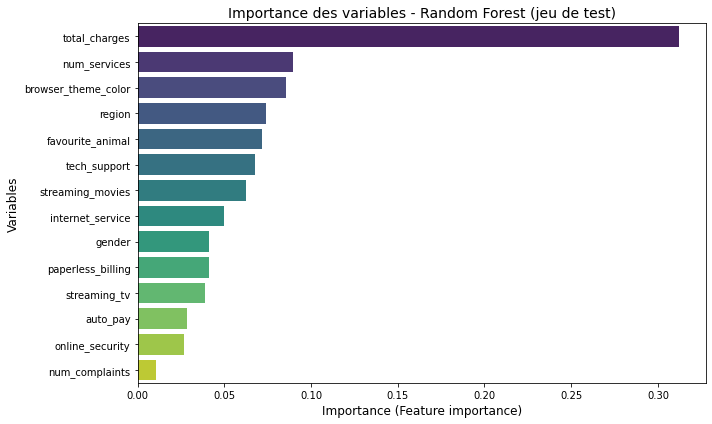

total_charges             : 0.3119
num_services              : 0.0894
browser_theme_color       : 0.0853
region                    : 0.0740
favourite_animal          : 0.0720


In [45]:
importances = rf_final.feature_importances_

indices = np.argsort(importances)[::-1]
features_sorted = np.array(X_test_best.columns)[indices]

plt.figure(figsize=(10, 6))
sns.barplot(
    x=importances[indices],
    y=features_sorted,
    palette="viridis"
)
plt.title("Importance des variables - Random Forest (jeu de test)", fontsize=14)
plt.xlabel("Importance (Feature importance)", fontsize=12)
plt.ylabel("Variables", fontsize=12)
plt.tight_layout()
plt.show()

for feat, imp in zip(features_sorted[:5], importances[indices][:10]):
    print(f"{feat:<25} : {imp:.4f}")


### Applying XGboost to our dataset 

Considering the important number of our parameters to tune, we're trying to find a first approximation of what our optimum parameters would look like.

In [46]:
# Définition du modèle de base
xgb = XGBClassifier(
    objective="binary:logistic",
    use_label_encoder=False,
    eval_metric="auc",
    subsample=0.9,
    tree_method="gpu_hist",
    random_state=0
)

# Grille d’hyperparamètres à tester
param_grid = {
    "n_estimators": [5, 10, 15, 20],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.5, 1, 1.5],
    "max_depth": [3, 5, 7 , 9, 11],
    "gamma": [0, 0.1, 0.5, 1, 1.5, 2], #Minimum loss reduction required to make a further partition on a leaf node of the tree.
    #"eval_metric": ["error", "auc"] 
}

# GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring="roc_auc",   # for sorting the dataframe
    cv=5,
    verbose=2,
    n_jobs=-1
)

# Entraînement
grid_search.fit(x_train, y_train)

# Meilleurs paramètres
print("Best params:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Fitting 5 folds for each of 840 candidates, totalling 4200 fits
Best params: {'gamma': 0.1, 'learning_rate': 0.5, 'max_depth': 11, 'n_estimators': 20}
Best score: 0.9350119816416171


In [47]:
df_result_XGB = pd.DataFrame.from_dict(grid_search.cv_results_)
df_result_XGB.drop(columns=['split0_test_score','split1_test_score','split2_test_score', 'split3_test_score', 'split4_test_score','mean_fit_time','std_fit_time', 'mean_score_time', 'std_score_time','std_test_score','rank_test_score'], inplace=True)

df_result_XGB.columns
df_result_XGB

param_gamma  param_learning_rate  param_max_depth  param_n_estimators  \
0            0.0                 0.01                3                   5   
1            0.0                 0.01                3                  10   
2            0.0                 0.01                3                  15   
3            0.0                 0.01                3                  20   
4            0.0                 0.01                5                   5   
..           ...                  ...              ...                 ...   
835          2.0                 1.50                9                  20   
836          2.0                 1.50               11                   5   
837          2.0                 1.50               11                  10   
838          2.0                 1.50               11                  15   
839          2.0                 1.50               11                  20   

                                                params  mean_test_score  
0    {'gamma': 0, 'learning_rate': 0.01, 'max_depth...         0.726223  
1    {'gamma': 0, 'learning_rate': 0.01, 'max_depth...         0.733581  
2    {'gamma': 0, 'learning_rate': 0.01, 'max_depth...         0.736853  
3    {'gamma': 0, 'learning_rate': 0.01, 'max_depth...         0.742497  
4    {'gamma': 0, 'learning_rate': 0.01, 'max_depth...         0.774632  
..                                                 ...              ...  
835  {'gamma': 2, 'learning_rate': 1.5, 'max_depth'...         0.877566  
836  {'gamma': 2, 'learning_rate': 1.5, 'max_depth'...         0.858053  
837  {'gamma': 2, 'learning_rate': 1.5, 'max_depth'...         0.874327  
838  {'gamma': 2, 'learning_rate': 1.5, 'max_depth'...         0.880900  
839  {'gamma': 2, 'learning_rate': 1.5, 'max_depth'...         0.882375  

[840 rows x 6 columns]

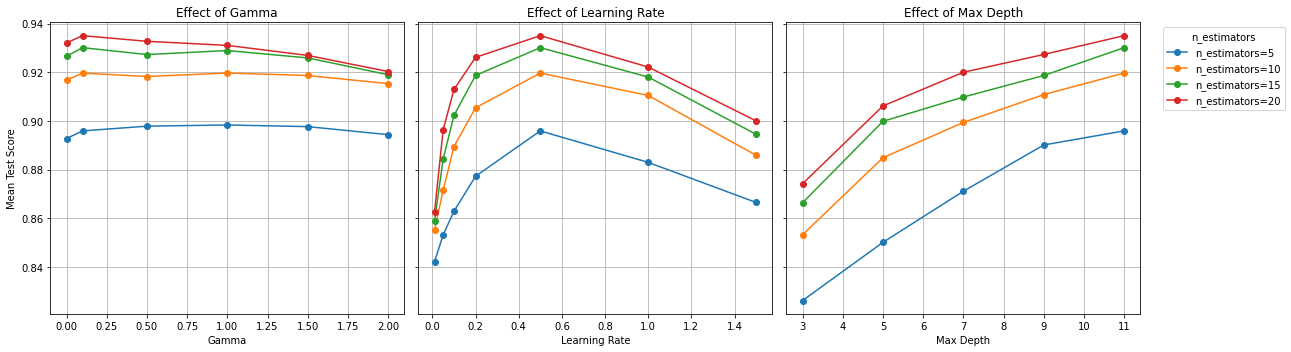

In [48]:
# Theoretical best values
best_params = {
    "param_gamma": 0.1, # Minimum loss reduction required to make a further partition on a leaf node of the tree.
    "param_learning_rate": 0.5,
    "param_max_depth": 11
}

# Create subplots: 3 side-by-side plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# Parameters to loop over
param_list = ["param_gamma", "param_learning_rate", "param_max_depth"]
titles = ["Effect of Gamma", "Effect of Learning Rate", "Effect of Max Depth"]

for ax, param, title in zip(axes, param_list, titles):
    # Filter df to keep only rows where the other parameters are fixed to best values
    mask = (
        (df_result_XGB["param_gamma"] == best_params["param_gamma"] if param != "param_gamma" else True) &
        (df_result_XGB["param_learning_rate"] == best_params["param_learning_rate"] if param != "param_learning_rate" else True) &
        (df_result_XGB["param_max_depth"] == best_params["param_max_depth"] if param != "param_max_depth" else True)
    )
    df_filtered = df_result_XGB[mask]
    
    # Plot one line per n_estimators
    for n_est, group in df_filtered.groupby("param_n_estimators"):
        ax.plot(group[param], group["mean_test_score"], marker="o", label=f"n_estimators={n_est}")
    
    ax.set_title(title)
    ax.set_xlabel(param.replace("param_", "").replace("_", " ").title())
    ax.grid(True)

axes[0].set_ylabel("Mean Test Score")
axes[-1].legend(title="n_estimators", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()

### Backward Selection on XGBclassifier

Apllying a backward selection for all different value of our n_estimator paramater would be too long (estimated time : 8 hours) so we opted to apply it only on the most relevent value of that parameter which is **n_estimator=15** and **n_estimator=20**. 
We'll choose our "best model" from those two. 

In [49]:
estimator_range = [15,20]

models = []
scores = []

df_score = pd.DataFrame(columns=["model", "estimator_range", "number_of_variables", "selected_featured", "metric", "score"])

for n_estimators in estimator_range:
    model = XGBClassifier(objective="binary:logistic", n_estimators=n_estimators,use_label_encoder=False,eval_metric="auc",subsample=0.9,
                          learning_rate=0.5,max_depth=5,gamma=0.1,tree_method="gpu_hist", predictor="gpu_predictor",random_state=0)
    df_backward = backward(model, [roc_auc_score, accuracy_score], x_train, y_train, y_type="categorical", metrics_goal=["max","max"], metric_types=["probability_roc","error"],
              nb_folds=5, shuffle=False, random_state=None)
    
    df_backward['estimator_range'] = n_estimators
    df_score = pd.concat([df_score,df_backward], ignore_index=True)
    print(df_score)

df_score.to_csv('XGB_results.csv', index=False,header=True) 

estimated time for running : 3.0 min 19.56551742553711 seconds
Processed 1 models on 23 variables in 0.7230634689331055 seconds.
Processed 23 models on 22 variables in 20.82808017730713 seconds.
Processed 22 models on 21 variables in 19.462202787399292 seconds.
Processed 21 models on 20 variables in 18.0248064994812 seconds.
Processed 20 models on 19 variables in 15.360087871551514 seconds.
Processed 19 models on 18 variables in 14.864433288574219 seconds.
Processed 18 models on 17 variables in 12.770595788955688 seconds.
Processed 17 models on 16 variables in 12.895589351654053 seconds.
Processed 16 models on 15 variables in 11.540009260177612 seconds.
Processed 15 models on 14 variables in 11.78535509109497 seconds.
Processed 14 models on 13 variables in 11.661459684371948 seconds.
Processed 13 models on 12 variables in 9.100646495819092 seconds.
Processed 12 models on 11 variables in 8.243940114974976 seconds.
Processed 11 models on 10 variables in 7.195744276046753 seconds.
Process

In [50]:
df_result_XGB_score = pd.read_csv('XGB_results.csv')
df_result_XGB_score

model  estimator_range  \
0   XGBClassifier(base_score=None, booster=None, c...               15   
1   XGBClassifier(base_score=None, booster=None, c...               15   
2   XGBClassifier(base_score=None, booster=None, c...               15   
3   XGBClassifier(base_score=None, booster=None, c...               15   
4   XGBClassifier(base_score=None, booster=None, c...               15   
..                                                ...              ...   
87  XGBClassifier(base_score=None, booster=None, c...               20   
88  XGBClassifier(base_score=None, booster=None, c...               20   
89  XGBClassifier(base_score=None, booster=None, c...               20   
90  XGBClassifier(base_score=None, booster=None, c...               20   
91  XGBClassifier(base_score=None, booster=None, c...               20   

    number_of_variables                                  selected_featured  \
0                    23  ['age', 'gender', 'region', 'tenure_months', '...   
1                    23  ['age', 'gender', 'region', 'tenure_months', '...   
2                    22  ['age', 'gender', 'region', 'tenure_months', '...   
3                    22  ['age', 'gender', 'region', 'tenure_months', '...   
4                    21  ['age', 'gender', 'region', 'tenure_months', '...   
..                  ...                                                ...   
87                    3  ['streaming_movies', 'num_services', 'customer...   
88                    2          ['num_services', 'customer_satisfaction']   
89                    2      ['streaming_movies', 'customer_satisfaction']   
90                    1                          ['customer_satisfaction']   
91                    1                          ['customer_satisfaction']   

            metric     score  
0    roc_auc_score  0.899830  
1   accuracy_score  0.819069  
2    roc_auc_score  0.902036  
3   accuracy_score  0.824151  
4    roc_auc_score  0.901351  
..             ...       ...  
87  accuracy_score  0.814344  
88   roc_auc_score  0.851772  
89  accuracy_score  0.792228  
90   roc_auc_score  0.848561  
91  accuracy_score  0.795438  

[92 rows x 6 columns]

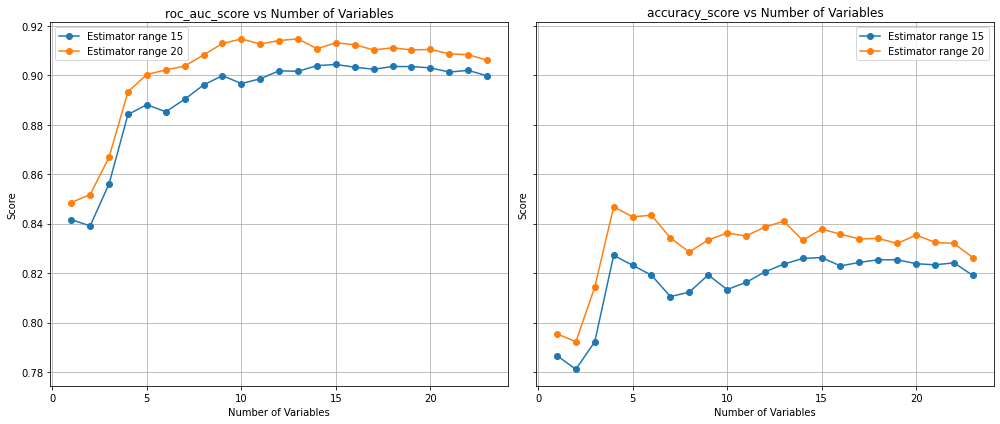

In [51]:
metrics_to_plot = ["roc_auc_score", "accuracy_score"]
estimator_ranges = [15, 20]

fig, axes = plt.subplots(1, 2, figsize=(14,6), sharey=True)

for ax, metric_name in zip(axes, metrics_to_plot):
    for est_range in estimator_ranges:
        subset = df_result_XGB_score[(df_result_XGB_score["metric"] == metric_name) & (df_result_XGB_score["estimator_range"] == est_range)]
        subset_sorted = subset.sort_values("number_of_variables")
        ax.plot(
            subset_sorted["number_of_variables"], 
            subset_sorted["score"], 
            marker="o", 
            label=f"Estimator range {est_range}"
        )
    
    ax.set_title(f"{metric_name} vs Number of Variables")
    ax.set_xlabel("Number of Variables")
    ax.set_ylabel("Score")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

In [70]:
df_selected_model = df_result_XGB_score[df_result_XGB_score["number_of_variables"] == 9]
for i in range(4):
    print(f"For {df_selected_model['estimator_range'].iloc[i]} estimator with the metric {df_selected_model['metric'].iloc[i]}")
    print(f"our selected features are {df_selected_model['selected_featured'].iloc[i]}")


For 15 estimator with the metric roc_auc_score
our selected features are ['contract_type', 'total_charges', 'payment_method', 'online_security', 'tech_support', 'streaming_tv', 'streaming_movies', 'num_services', 'customer_satisfaction']
For 15 estimator with the metric accuracy_score
our selected features are ['contract_type', 'total_charges', 'payment_method', 'online_security', 'tech_support', 'streaming_tv', 'streaming_movies', 'num_services', 'customer_satisfaction']
For 20 estimator with the metric roc_auc_score
our selected features are ['total_charges', 'payment_method', 'paperless_billing', 'tech_support', 'streaming_tv', 'streaming_movies', 'num_services', 'customer_satisfaction', 'auto_pay']
For 20 estimator with the metric accuracy_score
our selected features are ['total_charges', 'payment_method', 'paperless_billing', 'tech_support', 'streaming_tv', 'streaming_movies', 'num_services', 'customer_satisfaction', 'auto_pay']


## Final selection

The goal here is to determine which of our different type of model is the best overall using our x_test, y_train we left aside at the beginning of our testing part.


### Optimal Model for KNN

In [53]:
#Donc on garde le knn avec distance. 
knn_best = KNeighborsClassifier(n_neighbors=7, weights="distance")

knn_best.fit(x_train,y_train)

KNeighborsClassifier(n_neighbors=7, weights='distance')


Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.60      0.72      1424
           1       0.10      0.36      0.16       176

    accuracy                           0.58      1600
   macro avg       0.49      0.48      0.44      1600
weighted avg       0.80      0.58      0.66      1600



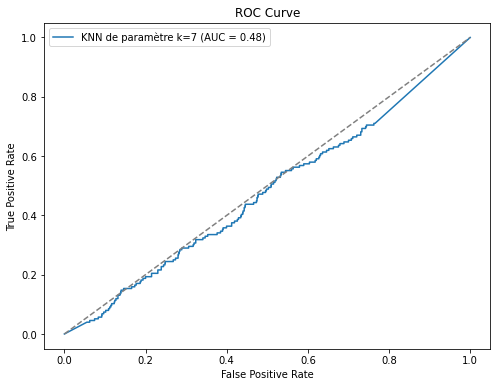

In [54]:
y_pred = knn_best.predict(x_test)
y_pred_proba = knn_best.predict_proba(x_test)[:,1]

print("\nClassification Report:\n", classification_report(y_test, y_pred))

# ROC Curve

roc_auc = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'KNN de paramètre k=7 (AUC = {roc_auc:.2f})')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

### Optimal Model for Bagging

In [71]:
n_estimators_opt = 15

x_train_bagging = x_train[['gender', 'region', 'total_charges', 'internet_service', 'online_security', 'tech_support', 'streaming_tv', 'streaming_movies', 'num_services', 'num_complaints', 'auto_pay', 'favourite_animal', 'browser_theme_color']]
x_test_bagging = x_test[['gender', 'region', 'total_charges', 'internet_service', 'online_security', 'tech_support', 'streaming_tv', 'streaming_movies', 'num_services', 'num_complaints', 'auto_pay', 'favourite_animal', 'browser_theme_color']]

bagging_model = BaggingClassifier(n_estimators = n_estimators_opt, oob_score=True, random_state = 22)

bagging_model.fit(x_train_bagging,y_train)

BaggingClassifier(n_estimators=15, oob_score=True, random_state=22)

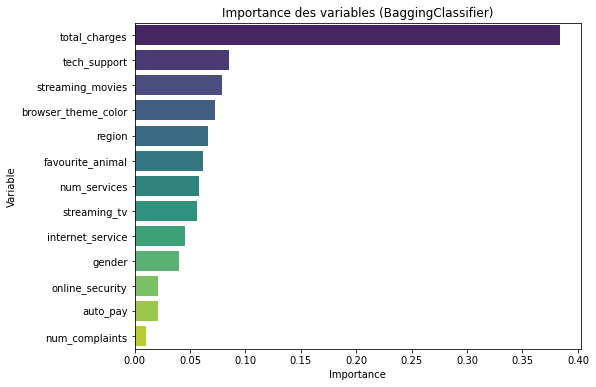

In [72]:
# Moyenne des importances de chaque arbre
importances = np.mean([tree.feature_importances_ for tree in bagging_model.estimators_], axis=0)

# DataFrame pour les résultats
features = x_train_bagging.columns
feat_importances = pd.DataFrame({
    "Feature": features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(8,6))
sns.barplot(data=feat_importances, x="Importance", y="Feature", palette="viridis")
plt.title("Importance des variables (BaggingClassifier)")
plt.xlabel("Importance")
plt.ylabel("Variable")
plt.show()


Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.87      0.88      1424
           1       0.13      0.15      0.14       176

    accuracy                           0.79      1600
   macro avg       0.51      0.51      0.51      1600
weighted avg       0.81      0.79      0.80      1600



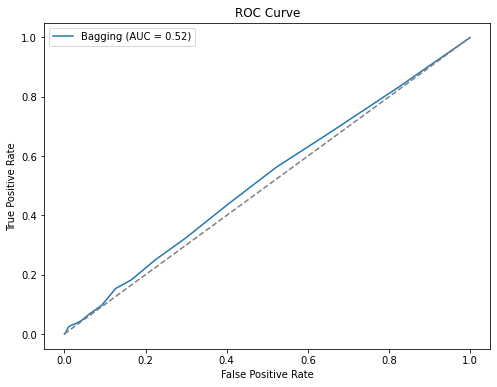

In [73]:
y_pred = bagging_model.predict(x_test_bagging)
y_pred_proba = bagging_model.predict_proba(x_test_bagging)[:,1]

print("\nClassification Report:\n", classification_report(y_test, y_pred))

# ROC Curve

roc_auc = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'Bagging (AUC = {roc_auc:.2f})')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

## Optimal Model for Random Forest

In [58]:

# Reprendre les 12 meilleures features car 12<14
X_train_best = x_train[best_features_rf]
X_test_best = x_test[best_features_rf]

rf_final = RandomForestClassifier(
    n_estimators=10,
    random_state=42,
    n_jobs=-1
)

# TRain
rf_final.fit(X_train_best, y_train)

# Test
y_pred_proba = rf_final.predict_proba(X_test_best)[:, 1]


auc_test = roc_auc_score(y_test, y_pred_proba)
print("AUC sur test :", auc_test)

AUC sur test : 0.5135202534473953


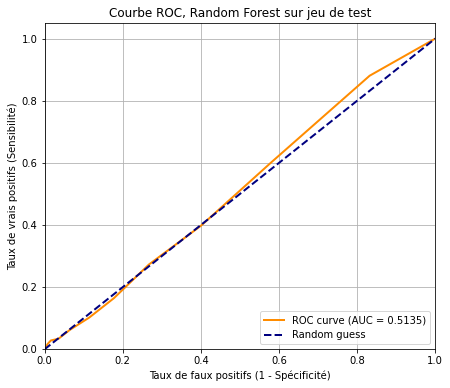

In [59]:
y_pred_proba = rf_final.predict_proba(X_test_best)[:, 1]


fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Tracé de la courbe
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random guess')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs (1 - Spécificité)')
plt.ylabel('Taux de vrais positifs (Sensibilité)')
plt.title('Courbe ROC, Random Forest sur jeu de test')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

accuracy_score = 0.799375


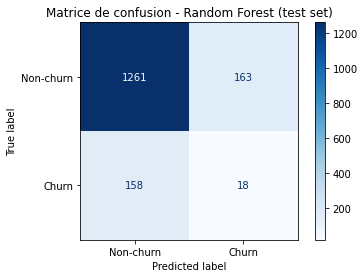

In [60]:
y_pred = rf_final.predict(X_test_best)

print("accuracy_score =", accuracy_score(y_test,y_pred))
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-churn", "Churn"])
disp.plot(cmap="Blues", values_format='d')
plt.title("Matrice de confusion - Random Forest (test set)")
plt.show()

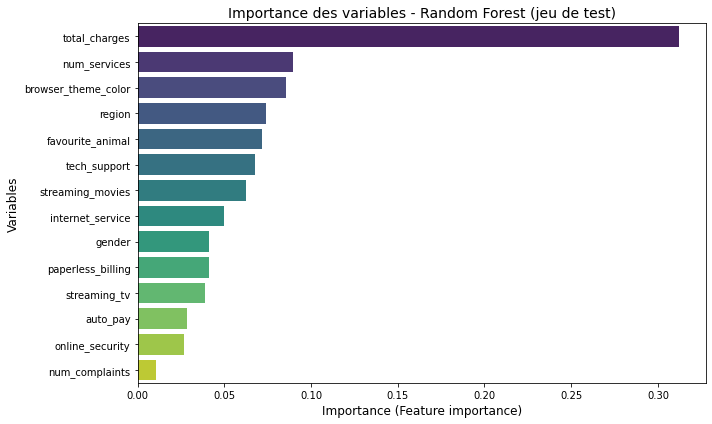

total_charges             : 0.3119
num_services              : 0.0894
browser_theme_color       : 0.0853
region                    : 0.0740
favourite_animal          : 0.0720


In [61]:
importances = rf_final.feature_importances_

indices = np.argsort(importances)[::-1]
features_sorted = np.array(X_test_best.columns)[indices]

plt.figure(figsize=(10, 6))
sns.barplot(
    x=importances[indices],
    y=features_sorted,
    palette="viridis"
)
plt.title("Importance des variables - Random Forest (jeu de test)", fontsize=14)
plt.xlabel("Importance (Feature importance)", fontsize=12)
plt.ylabel("Variables", fontsize=12)
plt.tight_layout()
plt.show()

for feat, imp in zip(features_sorted[:5], importances[indices][:10]):
    print(f"{feat:<25} : {imp:.4f}")


## Optimal Model for XGBclassifier

In [74]:
n_estimators_opt = 15
learning_rate_opt = 0.5
max_depth_opt = 5
gamma_opt = 0.1

x_train_XGB = x_train[['contract_type', 'total_charges', 'payment_method', 'online_security', 'tech_support', 'streaming_tv', 'streaming_movies', 'num_services', 'customer_satisfaction']]
x_test_XGB = x_test[['contract_type', 'total_charges', 'payment_method', 'online_security', 'tech_support', 'streaming_tv', 'streaming_movies', 'num_services', 'customer_satisfaction']]

XGB_model = XGBClassifier(objective="binary:logistic", n_estimators=n_estimators_opt,use_label_encoder=False,eval_metric="auc",subsample=0.9,
                          learning_rate=learning_rate_opt,max_depth=max_depth_opt,gamma=gamma_opt,tree_method="gpu_hist", predictor="gpu_predictor",random_state=0)


XGB_model.fit(x_train_XGB,y_train)



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=15, n_jobs=None,
              num_parallel_tree=None, predictor='gpu_predictor', ...)

In [75]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_importance(XGB_model, importance_type="gain", ax=ax)
plt.title("Importance des variables (XGBoost)")
plt.show()


Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.85      0.87      1424
           1       0.16      0.24      0.20       176

    accuracy                           0.78      1600
   macro avg       0.53      0.55      0.53      1600
weighted avg       0.82      0.78      0.80      1600



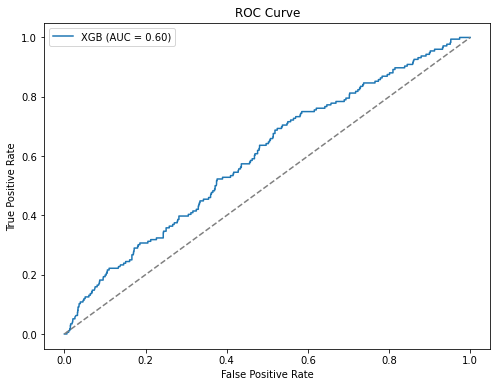

In [77]:
y_pred = XGB_model.predict(x_test_XGB)
y_pred_proba = XGB_model.predict_proba(x_test_XGB)[:,1]

print("\nClassification Report:\n", classification_report(y_test, y_pred))

# ROC Curve

roc_auc = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'XGB (AUC = {roc_auc:.2f})')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

## Results

Our results are as follows:

- **KNN:** Accuracy = 0.58, AUC = 0.48  
- **Bagging:** Accuracy = 0.79, AUC = 0.52 
- **Random Forest:** Accuracy = 0.79, AUC = 0.51
- **XGBoost Classifier:** Accuracy = 0.78, AUC = 0.60  

### Neural Network attempt

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                384       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 1,473
Trainable params: 1,473
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
701/701 [==============================] - 1s 784us/step - loss: 2.0440 - roc_auc: 0.5118
Epoch 2/100
701/701 [==============================] - 1s 767us/step - loss: 1.3813 - roc_auc: 0.5295
Epoch 3/100
701/701 [===========================

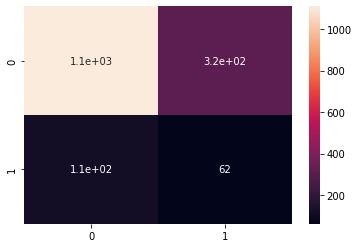

In [65]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential  
from tensorflow.keras.layers import Dense

model = Sequential([
    Dense(16, input_dim=23, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = [tf.keras.metrics.AUC(name='roc_auc')])
model.summary()

history = model.fit(x_train, y_train, epochs=100, batch_size=16, verbose = 1)

scores = model.evaluate(x_test, y_test)
y_pred_prob = model.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype("int32")

# evaluate the accuracy of the model
acc = accuracy_score(y_test, y_pred)

print("accuracy = ",acc)
print("roc_auc_score = ",roc_auc_score(y_test, y_pred_prob))
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)
sns.heatmap(confusion_matrix, annot=True)
plt.show()